In [7]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2

In [8]:
# Inspect some sample data
root = Path("data/Task06_Lung/imagesTr")
label = Path("data/Task06_Lung/labelsTr/")

In [9]:
# Load a sample NIfTI and its corresponding label mask
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object

In [10]:
sample_path = list(root.glob("lung*"))[2]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

sample_path, sample_path_label

(PosixPath('data/Task06_Lung/imagesTr/lung_037.nii.gz'),
 PosixPath('data/Task06_Lung/labelsTr/lung_037.nii.gz'))

In [12]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [13]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

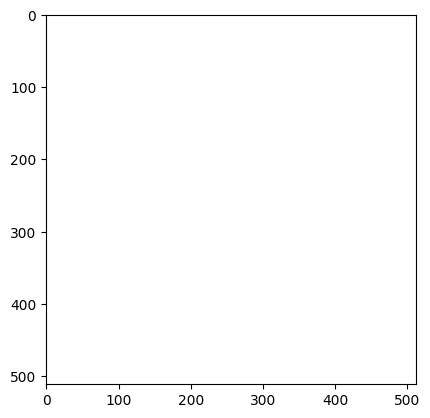

In [14]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5)
    camera.snap()

animation = camera.animate()

In [15]:
HTML(animation.to_html5_video())

## Preprocessing

In [16]:
all_files = list(root.glob('lung*'))

len(all_files)

63

In [18]:
save_root = Path('processed/Task06_Lung')

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
    path_to_label = change_img_to_label_path(path_to_ct_data)

    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    # Crop volume and label. Remove the first 30 slices
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]

    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root / "train" / str(counter)
    else:
        current_path = save_root / "val" / str(counter)

    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]

        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        slice_path = current_path / "data"
        mask_path = current_path / "masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path / str(i), slice)
        np.save(mask_path / str(i), mask)

  0%|          | 0/63 [00:00<?, ?it/s]

In [37]:
path = Path('processed/Task06_Lung/train/2')

file = '80.npy'
slice_data = np.load(path / 'data' / file)
mask = np.load(path / 'masks' / file)

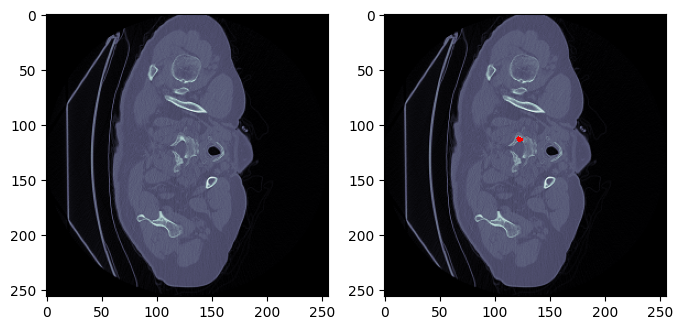

In [38]:
# Plot everything
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask == 0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

## Dataset Creation

In [39]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [40]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        super().__init__()
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []

        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject / "data"  # Get the slices for current subject

            for slice in slice_path.glob("*"):
                files.append(slice)

        return files


    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"

        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()

        return slice_aug, mask_aug

    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)


    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice_data = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice_data, mask = self.augment(slice_data, mask)

        return np.expand_dims(slice_data, 0), np.expand_dims(mask, 0)

In [41]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [42]:
path = Path('processed/Task06_Lung/train')
dataset = LungDataset(path, seq)

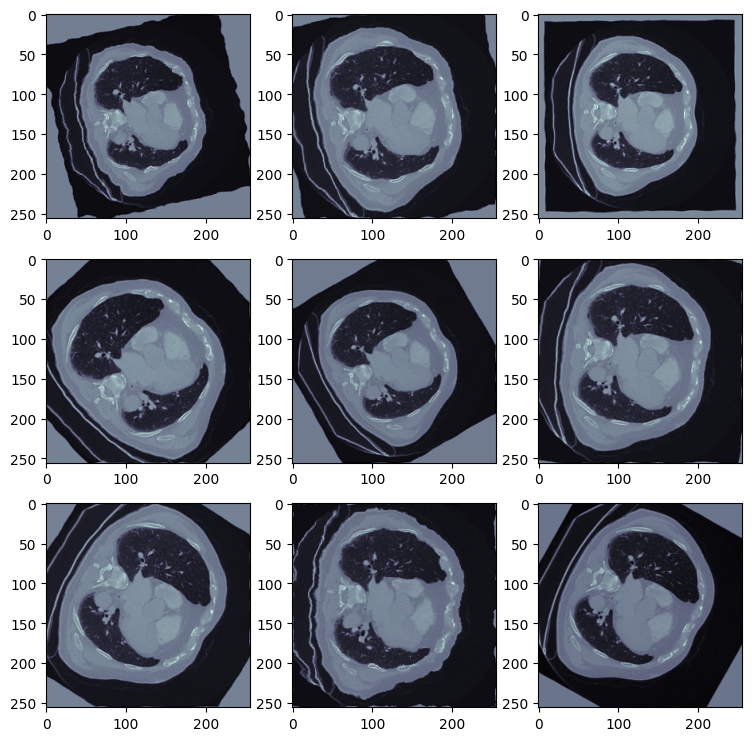

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice_data, mask = dataset[4]
        mask_ = np.ma.masked_where(mask == 0, mask)
        axes[i][j].imshow(slice_data[0], cmap='bone')
        axes[i][j].imshow(mask_[0])

In [1]:
%%writefile dataset.py
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        super().__init__()
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []

        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject / "data"  # Get the slices for current subject

            for slice in slice_path.glob("*"):
                files.append(slice)

        return files


    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"

        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()

        return slice_aug, mask_aug

    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)


    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice_data = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice_data, mask = self.augment(slice_data, mask)

        return np.expand_dims(slice_data, 0), np.expand_dims(mask, 0)

Writing dataset.py


## U-Net Model Implementation

In [45]:
import torch

class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, X):
        return self.step(X)

In [46]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.layer1 = DoubleConv(in_channels=1, out_channels=64)
        self.layer2 = DoubleConv(in_channels=64, out_channels=128)
        self.layer3 = DoubleConv(in_channels=128, out_channels=256)
        self.layer4 = DoubleConv(in_channels=256, out_channels=512)

        # Decoder layers
        self.layer5 = DoubleConv(in_channels=512 + 256, out_channels=256)
        self.layer6 = DoubleConv(in_channels=256 + 128, out_channels=128)
        self.layer7 = DoubleConv(in_channels=128 + 64, out_channels=64)
        self.layer8 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=1,
                                      kernel_size=1)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat(tensors=[x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat(tensors=[x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat(tensors=[x7, x1], dim=1)
        x7 = self.layer7(x7)

        # Final Segmentation
        ret = self.layer8(x7)

        return ret

In [47]:
model = UNet()

random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)

assert output.shape == torch.Size([1, 1, 256, 256])

In [2]:
%%writefile model.py
import torch

class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, X):
        return self.step(X)

class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.layer1 = DoubleConv(in_channels=1, out_channels=64)
        self.layer2 = DoubleConv(in_channels=64, out_channels=128)
        self.layer3 = DoubleConv(in_channels=128, out_channels=256)
        self.layer4 = DoubleConv(in_channels=256, out_channels=512)

        # Decoder layers
        self.layer5 = DoubleConv(in_channels=512 + 256, out_channels=256)
        self.layer6 = DoubleConv(in_channels=256 + 128, out_channels=128)
        self.layer7 = DoubleConv(in_channels=128 + 64, out_channels=64)
        self.layer8 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=1,
                                      kernel_size=1)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat(tensors=[x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat(tensors=[x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat(tensors=[x7, x1], dim=1)
        x7 = self.layer7(x7)

        # Final Segmentation
        ret = self.layer8(x7)

        return ret

Writing model.py


## Oversampling

In [49]:
from pathlib import Path
import torch
import numpy as np

from dataset import LungDataset

In [50]:
train_dataset = LungDataset(Path('processed/Task06_Lung/train'), None)

target_list = []

for _, label in train_dataset:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

unique = np.unique(target_list, return_counts=True)
unique

(array([0, 1]), array([13047,  1566]))

In [59]:
fraction = 13047 / 1566
fraction

8.331417624521073

In [60]:
weight_list = []

for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [61]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           sampler=sampler) # It is not possible to pass both 'sampler' and 'shuffle' arguments

In [62]:
for data, label in train_loader:
    print(label.sum([1, 2, 3]))

tensor([ 0, 17,  0,  0])
tensor([ 79, 165,   0,   0])
tensor([  0,   0,   0, 439])
tensor([478,   0,   0,   0])
tensor([246,   0,   0,  57])
tensor([214,   0, 267,   0])
tensor([  0, 288,   0,   0])
tensor([   0,  758, 1979,    0])
tensor([256, 513,  19,   0])
tensor([137,  18,   0,  68])
tensor([1248,  256,    0,   45])
tensor([  0, 152, 530,   0])
tensor([ 84,   0, 142,   0])
tensor([0, 0, 0, 0])
tensor([ 189,    0, 1268,    0])
tensor([  0,   0,   0, 147])
tensor([  0, 116, 581,   0])
tensor([  0,   0, 815,   0])
tensor([  0,   0, 287, 843])
tensor([   0, 1865,  440,  185])
tensor([0, 0, 0, 0])
tensor([  0,   0,   0, 110])
tensor([  0, 175, 938,   0])
tensor([54, 49,  0,  0])
tensor([  0, 116, 195,   0])
tensor([145, 267, 291, 253])
tensor([146,   0, 529,   0])
tensor([  0,   0,   0, 531])
tensor([105, 269,   0, 138])
tensor([0, 0, 0, 7])
tensor([ 0, 95,  0,  6])
tensor([ 16, 244,   0,  30])
tensor([  0,   0, 212, 113])
tensor([0, 0, 0, 0])
tensor([  0, 142,   0,   0])
tensor([  0, 

In [63]:
train_loader_without_sampler = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4)

for data, label in train_loader_without_sampler:
    print(label.sum([1, 2, 3]))

tensor([0, 0, 0, 0])
tensor([ 0,  0, 22,  0])
tensor([ 0, 60,  0,  0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([24,  0,  0,  0])
tensor([ 0,  0, 50,  0])
tensor([ 0,  0, 23,  0])
tensor([0, 0, 0, 0])
tensor([0, 0, 4, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([5, 0, 0, 0])
tensor([50,  0,  0,  0])
tensor([3, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([ 0,  0, 78,  0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([50,  0,  0,  0])
tensor([ 0,  0, 60,  0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([ 0,  0, 24,  0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([26,  0,  0,  0])
tensor([ 0,  0,  0, 18])
tensor([ 0,  0,  0, 27])
tensor([0, 0, 0, 0])
tensor([ 0,  0, 25,  0])
tensor([ 0,  0,  0, 71])
tensor([0, 0, 0,

## Data Loading

In [2]:
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import LungDataset
from model import UNet

In [57]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

train_path = Path("processed/Task06_Lung/train/")
val_path = Path("processed/Task06_Lung/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14613 train images and 1154 val images


In [58]:
batch_size = 8
num_workers = 0

sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               sampler=sampler,
                                               pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=False,
                                             pin_memory=True)

## Model Creation

In [3]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        pred = self.model(data)

        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        ct, mask = ct.float(), mask.float()
        pred = self(ct)

        loss = self.loss_fn(pred, mask)

        self.log('Train Loss', loss)

        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        ct, mask = ct.float(), mask.float()
        pred = self(ct)

        loss = self.loss_fn(pred, mask)

        self.log('Validation Loss', loss)

        if batch_idx % 2 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Validation")

        return loss

    def log_images(self, ct, pred, mask, name):
        pred = pred > 0.5

        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(ct[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axes[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axes[1].imshow(ct[0][0], cmap='bone')
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axes[1].imshow(mask_, alpha=0.6)
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f'{name} Prediction vs Label', fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [65]:
torch.manual_seed(42)

model = TumorSegmentation()

checkpoint_callback = ModelCheckpoint(monitor='Validation Loss',
                                      verbose=True,
                                      save_top_k=10,
                                      mode='min')

early_stopping_callback = EarlyStopping(monitor='Validation Loss',
                                        patience=3,
                                        verbose=True,
                                        mode='min')

In [66]:
trainer = pl.Trainer(accelerator='auto',
                     devices='auto',
                     logger=TensorBoardLogger(save_dir='logs'),
                     log_every_n_steps=1,
                     callbacks=[checkpoint_callback, early_stopping_callback],
                     max_epochs=30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\ROOTS\Desktop\temp\medicine\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\ROOTS\Desktop\temp\medicine\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19:  44%|████▍     | 797/1811 [11:11<14:14,  1.19it/s, v_num=3] 

c:\Users\ROOTS\Desktop\temp\medicine\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Model Evaluation

In [6]:
import nibabel as nib
import cv2
from tqdm.auto import tqdm
from celluloid import Camera

model = TumorSegmentation.load_from_checkpoint('logs/lightning_logs/version_3/checkpoints/epoch=11-step=21732.ckpt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval();
model.to(device)

TumorSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): 

In [68]:
preds = []
labels = []

for slice_data, label in tqdm(val_dataset):
    slice_data = torch.tensor(slice_data).to(device).unsqueeze(0)

    with torch.inference_mode():
        pred = model(slice_data)

    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1154 [00:00<?, ?it/s]

In [69]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denominator = pred.sum() + mask.sum() + 1e-8 # denominator
        dice_score = (2 * counter) / denominator

        return dice_score

In [ ]:
# This means we almost have perfect predictions and really small error occur
1 - DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(1.0000)

In [7]:
subject = Path("C:/My files/VS Code/python/pytorch/medical/data/Task06_Lung/imagesTs/lung_091.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:, :, 30:]  # crop

In [8]:
segmentation = []
label = []
scan = []
THRESHOLD = 0.5

for i in range(ct.shape[-1]):
    slice_data = ct[:, :, i]
    slice_data = cv2.resize(slice_data, (256, 256))
    slice_data = torch.tensor(slice_data)
    scan.append(slice_data)
    slice_data = slice_data.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.inference_mode():
        pred = model(slice_data)[0][0].cpu()

    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

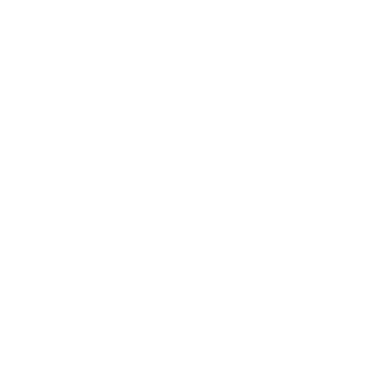

In [9]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i] == 0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation

    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [73]:
from IPython.display import HTML

HTML(animation.to_html5_video())  # convert the animation to a video